<a href="https://colab.research.google.com/github/FatemehAbediK/image-processing/blob/main/brain_mri_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


kaggle!!!

In [1]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatemehabedik","key":"6817536e536b38fb1335b3e08111e4b1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99% 708M/714M [00:10<00:00, 101MB/s] 
100% 714M/714M [00:11<00:00, 66.9MB/s]


In [6]:
!unzip '/content/lgg-mri-segmentation.zip' -d '/content/lgg-mri-segmentation'

Streaming output truncated to the last 5000 lines.
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/lgg-mri-segmentation/lgg-

In [7]:
import pandas as pd
data = pd.read_csv('/content/lgg-mri-segmentation/kaggle_3m/data.csv')

In [8]:
data.head()


,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
##optional:save to drive!
"""
from google.colab import drive
drive.mount('/content/drive')
!cp lgg-mri-segmentation.csv /content/drive/My Drive/
"""



In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [10]:
im_width = 256
im_height = 256
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m//*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
print(len(image_filenames_train))

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_13.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_11.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_12.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_7.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_5.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_6.tif']
3929


In [11]:
def plot_from_img_path(rows , columns , list_img_path , list_mask_path):
  fig=plt.figure(figsize=(3,3))
  for i in range(1 , rows * columns + 1):
    fig.add_subplot(rows , columns , i)
    img_path=list_img_path[i]
    mask_path=list_mask_path[i]
    image=cv2.imread(img_path)
    image=cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)
    mask=cv2.imread(mask_path)
    plt.imshow(image)
    plt.imshow(mask , alpha=0.4)
  plt.show();


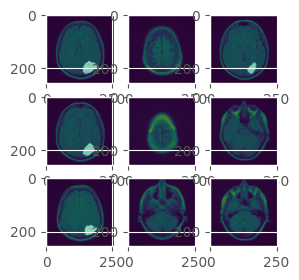

In [12]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files)

In [13]:
import pandas as pd

df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)



In [14]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [16]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):

    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,                    #binary,categorical,None,sparse:mode for yielding the target
        color_mode=image_color_mode,        #rgb,rgba,gray scale
        target_size=target_size,            #height & weight
        batch_size=batch_size,
        save_to_dir=save_to_dir,            #how to save
        save_prefix=image_save_prefix,      #how to save
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

        #yield instead of return because we are going to have each of them for each batch!!!

In [17]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)


U-Net

In [19]:
import tensorflow as tf
from tensorflow import keras

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
EPOCHS = 10
BATCH_SIZE = 16
learning_rate = 1e-4
SMOOTH=100

train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

decay_rate = learning_rate / EPOCHS

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [ModelCheckpoint('unet.hdf5.keras', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=int(len(df_train) / BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=int(len(df_val) / BATCH_SIZE))


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9668 - loss: 0.1708Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.07340, saving model to unet.hdf5.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 451ms/step - accuracy: 0.9669 - loss: 0.1703 - val_accuracy: 0.9906 - val_loss: 0.0734
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9897 - loss: 0.0473
Epoch 2: val_loss improved from 0.07340 to 0.04364, saving model to unet.hdf5.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 385ms/step - accuracy: 0.9897 - loss: 0.0473 - val_accuracy: 0.9905 - val_loss: 0.0436
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9895 - loss: 0.0399
Epoch 3: val_loss improved from 0.04364 to 0.03525, saving model to unet.hdf5.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 363ms/step - accuracy: 0.9895 - loss: 0.0399 - val_accuracy: 0.9

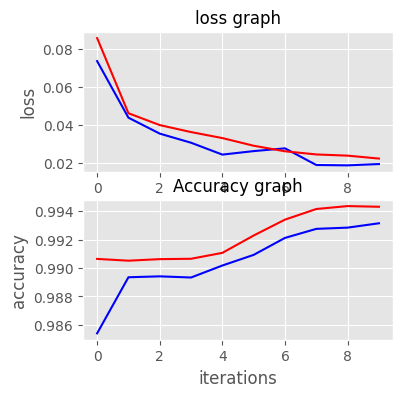

In [31]:
history_post_training = history.history

train_accuracy_list = history_post_training['accuracy']
test_accuracy_list  = history_post_training['val_accuracy']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(figsize=(4,4))
plt.subplot(211)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.subplot(212)
plt.plot(train_accuracy_list, 'b-')
plt.plot(test_accuracy_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9937 - loss: 0.0218
Test Loss: 0.020779114216566086
Test Accuracy: 0.9940573573112488
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


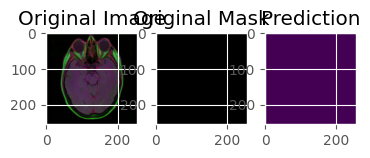

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


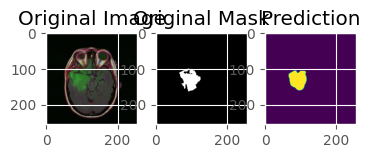

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


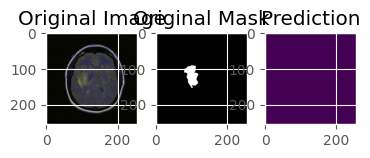

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


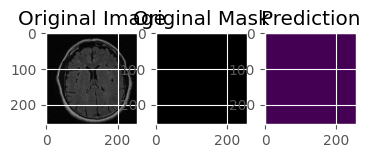

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


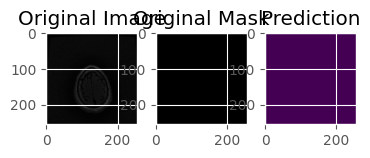

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


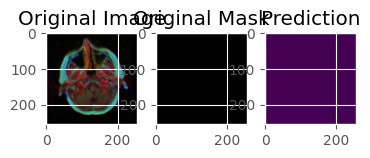

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


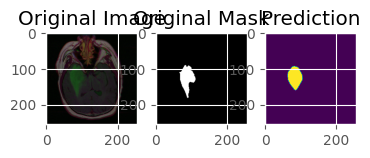

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


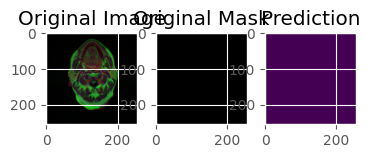

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


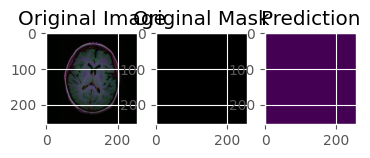

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


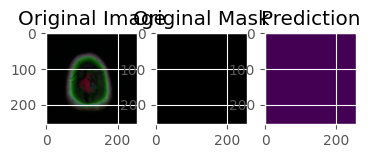

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


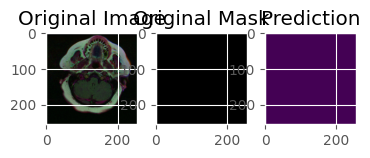

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


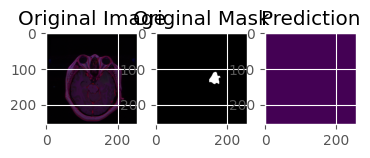

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


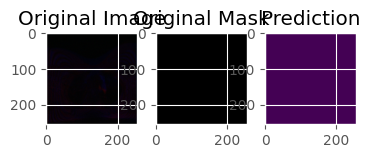

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


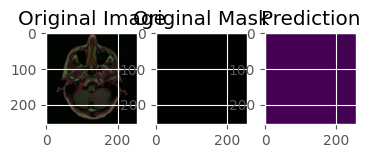

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


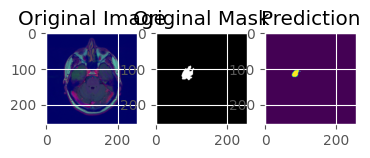

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


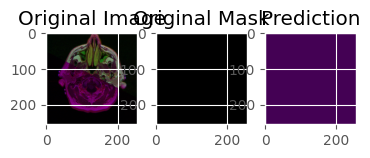

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


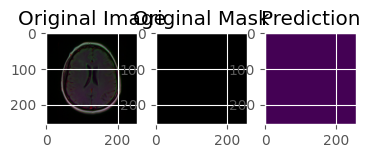

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


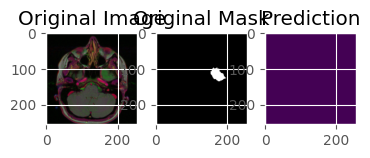

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


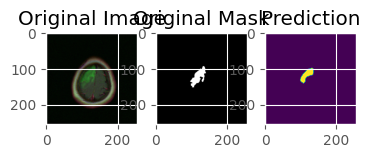

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


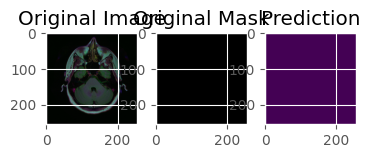

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Define Dice Coefficients
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2. * intersection + smooth) / (union + smooth)

# Define Dice Coefficients Loss
def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth=smooth)

# Define IoU (Intersection over Union)
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    return (intersection + smooth) / (sum_ - intersection + smooth)

# Jaccard Distance (IoU as Loss)
def jaccard_distance(y_true, y_pred, smooth=100):
    return -iou(y_true, y_pred, smooth=smooth)

# Evaluation on Test Data
test_loss, test_accuracy = model.evaluate(test_gen, steps=int(len(df_val) / BATCH_SIZE))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Random Image Prediction Visualization
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img / 255.0
    img = img[np.newaxis, :, :, :]  # Add batch dimension

    predicted_img = model.predict(img)

    plt.figure(figsize=(4,4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5)
    plt.title('Prediction')
    plt.show()
